In [1]:
import pandas as pd
import hepunits as u
import mplhep
import hist

In [2]:
df = pd.read_hdf("data/KS_sample.h5")
df

0        492.820074
1        498.053288
2        492.820074
3        498.053288
4        455.650822
            ...    
13499    498.473999
13500    498.473999
13502    536.352292
13504    467.745323
13512    489.696223
Name: KS_M, Length: 8638, dtype: float64

<Axes: ylabel='Frequency'>

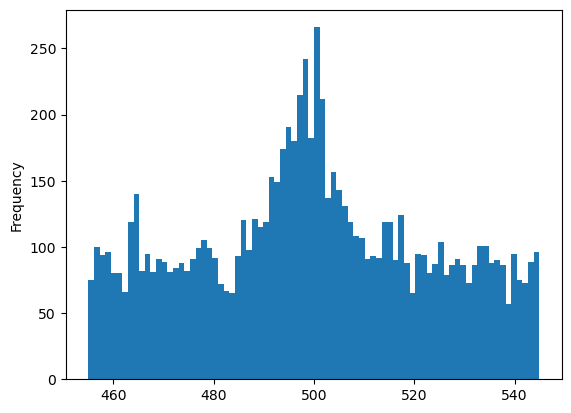

In [3]:
df.plot.hist(bins=80)

In [4]:
import iminuit
from iminuit.cost import UnbinnedNLL
from iminuit import Minuit
import numpy as np
#import numba as nb
import boost_histogram as bh
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from scipy.stats import truncnorm, truncexpon

In [5]:
ax_x = bh.axis.Regular(40, 460, 540)
h = bh.Histogram(ax_x)
#h.fill(df[mask4 & mask3]['KS_M'].values)
h.fill(df.values)
h

Histogram(Regular(40, 460, 540), storage=Double()) # Sum: 7869.0 (8638.0 with flow)

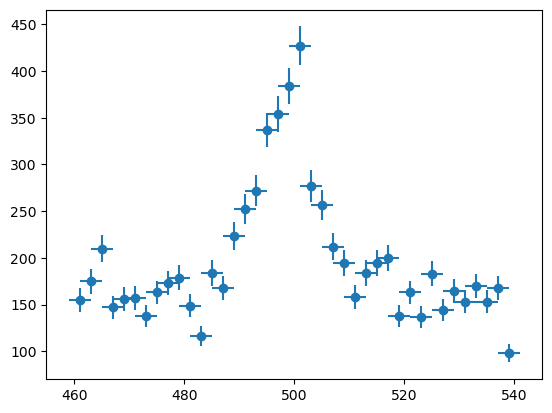

In [6]:
px_axis = h.axes[0]
cx = px_axis.centers
dx = px_axis.widths
xe = px_axis.edges
n = h.view()

plt.errorbar(cx, n, n**0.5, dx, fmt="o", label="data");

In [7]:
xmix = df.values

In [8]:
import zfit

C:\home\sw\anaconda3\envs\STFC_DIS_2024\Lib\site-packages\zfit\__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [9]:
import numpy as np
import zfit
import matplotlib.pyplot as plt

n_bins = 40
xr = (460., 540.)  # xrange

# create space
#obs = zfit.Space("$K_S^0$ mass [MeV]", limits=xr)
obs = zfit.Space("KS_M", limits=xr)

# parameters
mu = zfit.Parameter("mu", 500., 450., 550.)
sigma = zfit.Parameter("sigma", 5., 0.1, 10)
lambd = zfit.Parameter("lambda", -0.1, -2., 2.)

In [10]:
df.to_frame()

KS_M
0      492.820074
1      498.053288
2      492.820074
3      498.053288
4      455.650822
...           ...
13499  498.473999
13500  498.473999
13502  536.352292
13504  467.745323
13512  489.696223

[8638 rows x 1 columns]

In [11]:
# model building, pdf creation
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)

n_bkg = zfit.Parameter('n_bkg', 6000)
n_sig = zfit.Parameter('n_sig', 1500)
gauss_extended = gauss.create_extended(n_sig)
exp_extended = exponential.create_extended(n_bkg)
model = zfit.pdf.SumPDF([gauss_extended, exp_extended])

# data
data = zfit.Data.from_pandas(df.to_frame(), obs=obs)

# set the values to a start value for the fit
#mu.set_value(0.5)
#sigma.set_value(1.2)
#lambd.set_value(-0.05)

# create NLL
nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)

# create a minimizer
minimizer = zfit.minimize.Minuit(verbosity=7)
result = minimizer.minimize(nll)
print(result.params)
# do the error calculations, here with hesse, than with minos
param_hesse = result.hesse()

param_errors, _ = result.errors()  # this returns a new FitResult if a new minimum was found
print(result.valid)  # check if the result is still valid

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       10003.60128 Edm =      -72530.54611 NCalls =     21
I NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
I MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -260.4875627
  Edm           : 36.85168756
  Internal parameters:	[             1500             6000                0   -0.01010118188  -0.001409066908]	
  Internal gradient  :	[   -0.00778777866   -0.05955306718      1211.209929     -65.07880699     -10633.03699]	
  Internal covariance matrix:
[[      5969.8305              0              0              0              0]
 [              0       12858.46              0              0              0]
 [              0              0  4.7972362e-05              0              0]
 [              0              0              0   0.0033550839              0]
 [              0              0              0             

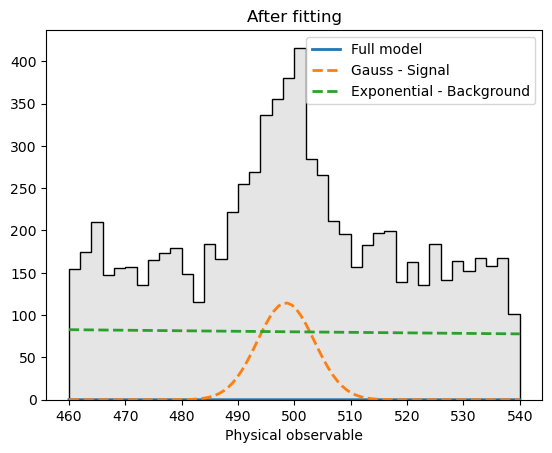

In [12]:
plt.figure()
plt.title("After fitting")

# plot the data
color = 'black'
n_bins = 40

plt.hist(data.numpy(), color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data.numpy(), color=color, bins=n_bins, histtype="step")

x = np.linspace(*xr, 100)

#
gauss_extended = gauss.create_extended(n_sig)
exp_extended = exponential.create_extended(n_bkg)
model = zfit.pdf.SumPDF([gauss_extended, exp_extended])
#

y = model.pdf(x).numpy()  # rerun now after the fitting
y_gauss = (gauss.pdf(x) * n_sig).numpy()
y_exp = (exponential.pdf(x) * n_bkg).numpy()

linewidth = 2

plot_scaling =  1#n_sample / n_bins * obs.area()
plt.plot(x, y * plot_scaling, label="Full model", linewidth=linewidth)
plt.plot(x, y_gauss * plot_scaling, '--', label="Gauss - Signal", linewidth=linewidth)
plt.plot(x, y_exp * plot_scaling, '--', label="Exponential - Background", linewidth=linewidth)
plt.xlabel("Physical observable")

plt.legend()

In [13]:
data['KS_M'].numpy()

array([492.82007366, 498.05328844, 492.82007366, ..., 536.35229211,
       467.74532333, 489.6962228 ])

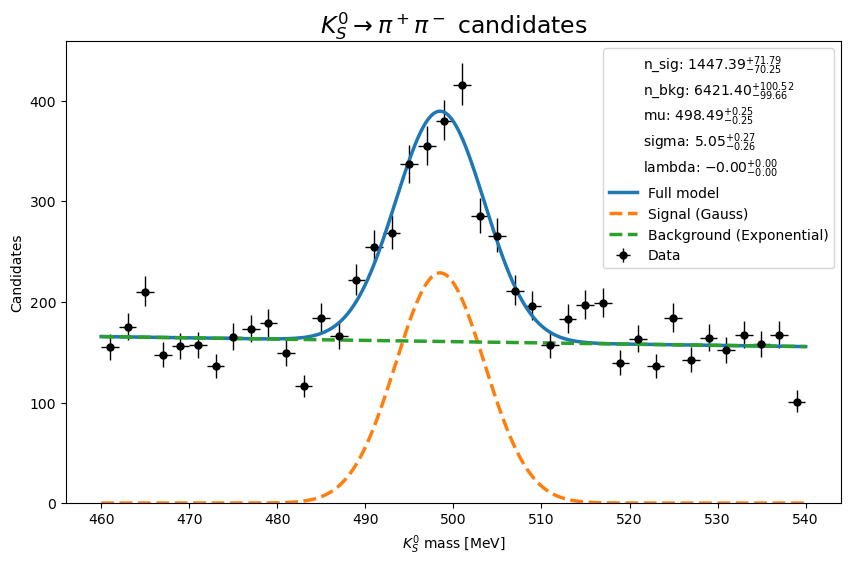

In [14]:
# In order to plot our model, a helper function is created
def plot_pdf_data(data, model, title, n_bins=40):
    linewidth = 2.5
    space = data.data_range
    plot_scaling = data.nevents / n_bins * space.area()
    lower, upper = space.limit1d
    x = np.linspace(lower, upper, 1000)

    plt.figure(figsize=[10,6])
    plt.title(title, fontsize=17)
   
    # plot the data
    data_np = data
    """
    plt.hist(data_np,
             color="black",
             bins=n_bins, histtype="stepfilled", alpha=0)
    plt.hist(data_np,
             color="black",
             bins=n_bins, histtype="step")
    """
    mplhep.histplot(
        np.histogram(data_np['KS_M'].numpy(), bins=n_bins),
        xerr=True,
        yerr=True,
        color="black",
        histtype="errorbar",
        label = "Data"
    )
    # plot the pdfs
    y = zfit.run(model.pdf(x))
    y_sig = zfit.run(model.pdfs[0].pdf(x) * model.fracs[0])# notice the frac!
    y_bkg = zfit.run(model.pdfs[1].pdf(x) * model.fracs[1])  # notice the frac!

    plt.plot(x, y * plot_scaling, label="Full model", color='tab:blue', linewidth=linewidth)
    plt.plot(x, y_sig * plot_scaling, '--', label="Signal (Gauss)", color='tab:orange', linewidth=linewidth)
    plt.plot(x, y_bkg * plot_scaling, '--', label="Background (Exponential)", color='tab:green', linewidth=linewidth)
    
    plt.xlabel("$K_S^0$ mass [MeV]")
    #plt.xlabel(space.obs[0])
    plt.ylabel("Candidates")
    
    # display legend with some fit info
    fit_info = []
    for v, tmp in zip(result.values,param_errors.items()):
        var, errors = tmp
        fit_info.append(f"{var.name}: ${v:.2f} ^{{+{errors['upper']:.2f}}}_{{{errors['lower']:.2f}}}$")
   
    plt.legend(title="\n".join(fit_info))

   
params = result.params
params[mu]['value']

title = r"$K_S^0 \rightarrow \pi^+ \pi^-$ candidates"
plot_pdf_data(data=data, model=model, title=title)

#plt.savefig("first-sneak-preview.png")
plt.show()

In [15]:
h = hist.Hist.new.Reg(100, 400, 600, name="mass [MeV]").Double()

In [16]:
h.fill(df)

Hist(Regular(100, 400, 600, name='mass [MeV]'), storage=Double()) # Sum: 8638.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x000001321091CE60>, errorbar=None, legend_artist=None)]

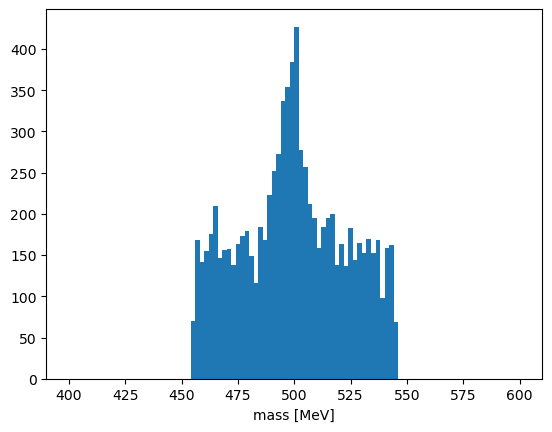

In [17]:
mplhep.histplot(h, histtype="fill")